In [6]:
%matplotlib inline
import matplotlib as mpl;
import matplotlib.pyplot as plt;
import pandas as pd
import zipfile

import numpy as np;
import gzip;
from io import StringIO; 

In [550]:
# import pandas as pd
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

raw_data = pd.read_csv('11B5EC4D-4133-4289-B475-4E737182A406.features_labels.csv')
# print(raw_data.head())

In [551]:
count = 0 
for i in raw_data.columns: 
    
    print(count, i)
    count +=1

0 timestamp
1 raw_acc:magnitude_stats:mean
2 raw_acc:magnitude_stats:std
3 raw_acc:magnitude_stats:moment3
4 raw_acc:magnitude_stats:moment4
5 raw_acc:magnitude_stats:percentile25
6 raw_acc:magnitude_stats:percentile50
7 raw_acc:magnitude_stats:percentile75
8 raw_acc:magnitude_stats:value_entropy
9 raw_acc:magnitude_stats:time_entropy
10 raw_acc:magnitude_spectrum:log_energy_band0
11 raw_acc:magnitude_spectrum:log_energy_band1
12 raw_acc:magnitude_spectrum:log_energy_band2
13 raw_acc:magnitude_spectrum:log_energy_band3
14 raw_acc:magnitude_spectrum:log_energy_band4
15 raw_acc:magnitude_spectrum:spectral_entropy
16 raw_acc:magnitude_autocorrelation:period
17 raw_acc:magnitude_autocorrelation:normalized_ac
18 raw_acc:3d:mean_x
19 raw_acc:3d:mean_y
20 raw_acc:3d:mean_z
21 raw_acc:3d:std_x
22 raw_acc:3d:std_y
23 raw_acc:3d:std_z
24 raw_acc:3d:ro_xy
25 raw_acc:3d:ro_xz
26 raw_acc:3d:ro_yz
27 proc_gyro:magnitude_stats:mean
28 proc_gyro:magnitude_stats:std
29 proc_gyro:magnitude_stats:moment3

In [5]:
def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index(b'\n')];
    columns = headline.split(b',');

    # The first column should be timestamp:
    assert columns[0] == b'timestamp';
    # The last column should be label_source:
    assert columns[-1] == b'label_source';
    
    # Search for the column of the first label:
    for (ci,col) in enumerate(columns):
        if col.startswith(b'label:'):
            first_label_ind = ci;
            break;
        pass;

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li,label) in enumerate(label_names):
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith(b'label:');
        label_names[li] = label.replace(b'label:',b'');
        pass;
    
    return (feature_names,label_names);

def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO(csv_str.decode("utf-8")),delimiter=',',skiprows=1);
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int);
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)];
    
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:,(n_features+1):-1]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    
    return (X,Y,M,timestamps);

'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''
def read_user_data(uuid):
    user_data_file = '%s.features_labels.csv.gz' % uuid;

    # Read the entire csv file of the user:
    with gzip.open(user_data_file,'rb') as fid:
        csv_str = fid.read();
        pass;
    
    (feature_names,label_names) = parse_header_of_csv(csv_str);
    n_features = len(feature_names);
    (X,Y,M,timestamps) = parse_body_of_csv(csv_str,n_features);

    return (X,Y,M,timestamps,feature_names,label_names);

In [6]:
uuid = '1155FF54-63D3-4AB2-9863-8385D0BD0A13';
(X,Y,M,timestamps,feature_names,label_names) = read_user_data(uuid);
feature_names = [i.decode("utf-8") for i in feature_names]
label_names = [i.decode("utf-8") for i in label_names]

In [7]:
print(timestamps)

[1464129912 1464129950 1464130031 ... 1464887023 1464887322 1464887622]


In [8]:
print(label_names)
print(len(label_names))

['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'SLEEPING', 'LAB_WORK', 'IN_CLASS', 'IN_A_MEETING', 'LOC_main_workplace', 'OR_indoors', 'OR_outside', 'IN_A_CAR', 'ON_A_BUS', 'DRIVE_-_I_M_THE_DRIVER', 'DRIVE_-_I_M_A_PASSENGER', 'LOC_home', 'FIX_restaurant', 'PHONE_IN_POCKET', 'OR_exercise', 'COOKING', 'SHOPPING', 'STROLLING', 'DRINKING__ALCOHOL_', 'BATHING_-_SHOWER', 'CLEANING', 'DOING_LAUNDRY', 'WASHING_DISHES', 'WATCHING_TV', 'SURFING_THE_INTERNET', 'AT_A_PARTY', 'AT_A_BAR', 'LOC_beach', 'SINGING', 'TALKING', 'COMPUTER_WORK', 'EATING', 'TOILET', 'GROOMING', 'DRESSING', 'AT_THE_GYM', 'STAIRS_-_GOING_UP', 'STAIRS_-_GOING_DOWN', 'ELEVATOR', 'OR_standing', 'AT_SCHOOL', 'PHONE_IN_HAND', 'PHONE_IN_BAG', 'PHONE_ON_TABLE', 'WITH_CO-WORKERS', 'WITH_FRIENDS']
51


In [9]:
Y.shape 

(2685, 51)

In [10]:
X.shape

(2685, 225)

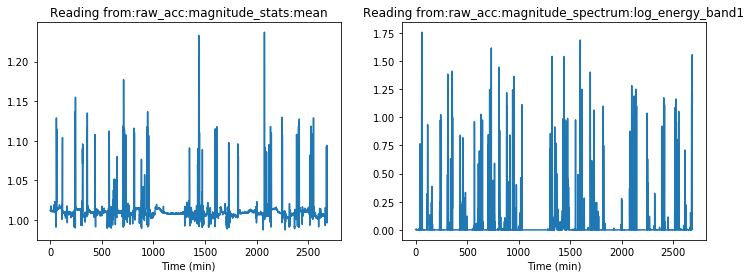

In [11]:
t = [i for i in range(len(X[:,0]))]
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t,X[:,0])
plt.xlabel('Time (min)')
plt.title('Reading from:'+feature_names[0])
plt.subplot(122)
plt.plot(t,X[:,10])
plt.xlabel('Time (min)')
plt.title('Reading from:'+feature_names[10])
plt.show()

In [1]:
from os import listdir
from os.path import isfile, join
import gzip
import shutil

mypath = '/Users/ferlejarza/Desktop/ut_austin/4th_semester/EE380_data_mining/project/ExtraSensory.per_uuid_features_labels'
onlyfiles = [f for f in listdir(mypath)]
onlyfiles.remove('.DS_Store')
current_path = '/ExtraSensory.per_uuid_features_labels/'
final_files = [] 
for i in onlyfiles: 
    x = current_path+i[0:len(i)-4] 
    final_files.append(x)
    


In [2]:
# for idx in range(len(final_files)):
#     with gzip.open('.'+final_files[idx]+'.csv.gz', 'rb') as f_in:
#                 with open('.'+final_files[idx]+'.csv', 'wb') as f_out:
#                     shutil.copyfileobj(f_in, f_out)
            

In [20]:
import torch 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import seaborn as sns 

Index(['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std',
       'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4',
       'raw_acc:magnitude_stats:percentile25',
       'raw_acc:magnitude_stats:percentile50',
       'raw_acc:magnitude_stats:percentile75',
       'raw_acc:magnitude_stats:value_entropy',
       'raw_acc:magnitude_stats:time_entropy',
       'raw_acc:magnitude_spectrum:log_energy_band0',
       ...
       'audio_naive:mfcc2:std', 'audio_naive:mfcc3:std',
       'audio_naive:mfcc4:std', 'audio_naive:mfcc5:std',
       'audio_naive:mfcc6:std', 'audio_naive:mfcc7:std',
       'audio_naive:mfcc8:std', 'audio_naive:mfcc9:std',
       'audio_naive:mfcc10:std', 'audio_naive:mfcc11:std'],
      dtype='object', length=180)

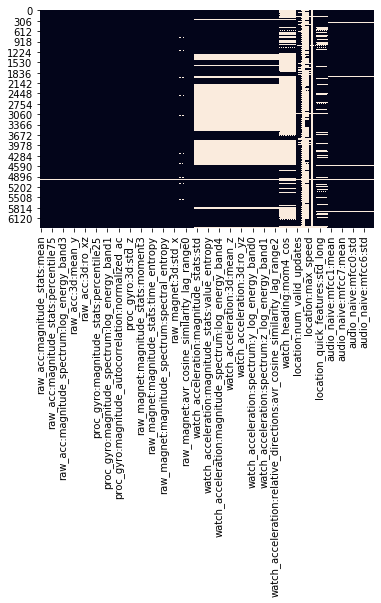

In [209]:
# Visualizing NaN entries in sensor reading
raw_d = pd.read_csv('.'+final_files[0]+'.csv')
sensor_data = raw_d.iloc[:,1:181]
sns.heatmap(sensor_data.isnull(), cbar=False)
# for index, row in sensor_data.iterrows():
#     print(row.isnull())
sensor_data.columns

In [210]:
# Filling NaN with column mode, and dropping remaining NaN
sensor_data[sensor_data.columns]=sensor_data[sensor_data.columns].fillna(sensor_data.mean().iloc[0])
sensor_data.dropna(inplace = True, axis = 'columns' )
sensor_data.shape
modes = sensor_data.mode()  

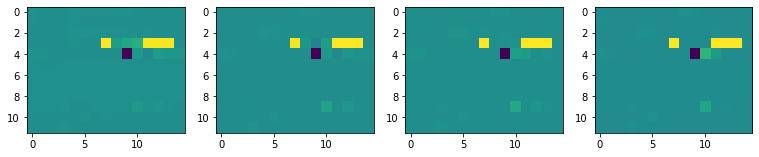

In [211]:
plt.figure(figsize = (13,6))
plt.title('Unnormalizaed data')
for i in range(4): 
    ax = plt.subplot(1,4,i+1)
    row_i = sensor_data.iloc[i,:].to_numpy().reshape(12,15)
    plt.imshow(row_i)

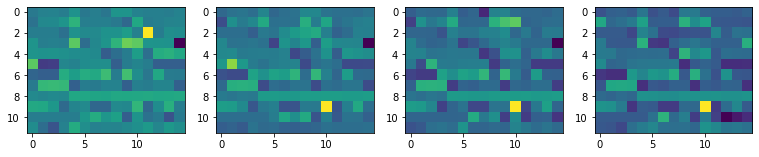

In [213]:
norm_sensor_data = pd.DataFrame() 

for col in sensor_data.columns: 
    col_mean = sensor_data[col].mean()
    col_std = sensor_data[col].std()
    norm_sensor_data[col] = (sensor_data[col] - col_mean)/col_std

    
plt.figure(figsize = (13,6))
plt.title('Normalized data')
for i in range(4): 
    ax = plt.subplot(1,4,i+1)
    row_i = norm_sensor_data.iloc[i,:].to_numpy().reshape(12,15)
    plt.imshow(row_i)

In [214]:
# min_dim = 1e10
# for idx in range(len(final_files)): 
#     raw_data = pd.read_csv('.'+final_files[idx]+'.csv')
#     if min_dim > raw_data.shape[0]: 
#         min_dim = raw_data.shape[0]

# print(min_dim)

# new_file_list = [] 

# for idx in range(len(final_files)): 
#     raw_data1 = pd.read_csv('.'+final_files[idx]+'.csv')
#     if min_dim < raw_data1.shape[0]: 
        
        
#         sensor_data = raw_data1.iloc[:,acc_gyr_ind]
#         sensor_data.dropna(inplace = True)
#         x = sensor_data.shape[0]
        
#         print(final_files[idx])
#         if x == 0:
#             continue 
#         sensor_data_sample = sensor_data.sample(min_dim,random_state=1)
#         new_file_list.append(final_files[idx])
#         print(x)

In [227]:
class SensorDataset(Dataset): 
    
    def __init__(self, sensor_data, rows, transform):
        """provide directory with the user's data"""
        self.sensor_data = sensor_data
        self.rows = rows
        self.transform = transform
        
    def __len__(self):
        return len(self.rows)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
#         rd = pd.read_csv('.'+self.file_name+'.csv')
#         sd = rd.iloc[:,1:226]
#         sd[sd.columns]=sd[sd.columns].fillna(sd.mode().iloc[0])
#         sd.dropna(inplace = True, axis = 'columns' )
        
#         n_sd = pd.DataFrame()
#         for col in sd.columns: 
#             col_mean = sd[col].mean()
#             col_std = sd[col].std()
#             n_sd[col] = (sd[col] - col_mean)/col_std
        
        sample =  self.sensor_data.iloc[idx,:]
        
        if self.transform:
            # Transform to tensor
            sample = self.transform(sample.to_numpy().reshape(12,15))
        return sample 
    

# Construct 2 d image 
def reshape_img(tensor,w,h):
    return tensor.reshape([w,h])

# min-max normalization  
def min_max_norm(tensor, min_value, max_value):
    min_val = tensor.min()
    tensor = (tensor - min_val)
    max_val = tensor.max()
    tensor = tensor / max_val
    tensor = tensor * (max_val - min_val) + min_val
    return tensor 

img_transform = transforms.Compose([
    transforms.ToTensor()])
#     transforms.Lambda(lambda tensor:min_max_norm(tensor, 0, 1)),
#     transforms.Lambda(lambda tensor:reshape_img(tensor,11,20))


In [228]:
row_train = [i for i in range(int(2*6407/3))]
row_test = [i for i in range(int(2*6407/3),6407)]     

train_data_set = SensorDataset(sensor_data=norm_sensor_data, rows =row_train, transform=img_transform)
test_data_set = SensorDataset(sensor_data=norm_sensor_data, rows =row_test, transform=img_transform)

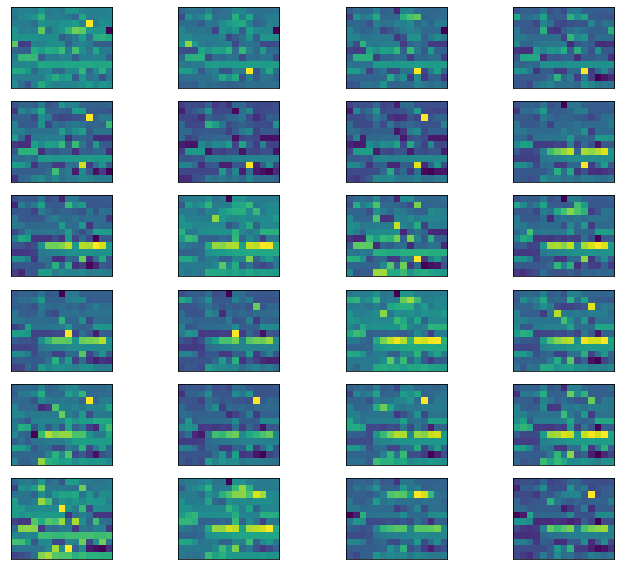

In [229]:
fig = plt.figure(figsize=(10, 8))
count = 0 
for i in range(24):
    ax = plt.subplot(6,4,count+1)
    
    im = train_data_set[count]

    ax.set_xticks([]) 
    ax.set_yticks([])
    plt.imshow(im.numpy().squeeze() )
    
    count +=1
fig.tight_layout(pad=1.0)

In [230]:
train_dataset_loader = torch.utils.data.DataLoader(train_data_set, batch_size=20, shuffle=True)


In [231]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=kwargs["input_shape"],out_features=100),
            nn.ReLU(True),
            nn.Linear(100, 64),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(64, 100),
            nn.ReLU(True),
            nn.Linear(in_features= 100, out_features=kwargs["input_shape"]))
        
#         self.encoder_hidden_layer = nn.Linear(
#             in_features=kwargs["input_shape"], out_features=128
#         )
#         self.encoder_output_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_hidden_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_output_layer = nn.Linear(
#             in_features=128, out_features=kwargs["input_shape"]
#         )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [232]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [233]:
model = AE(input_shape=180).to(device)

In [234]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [235]:
criterion = nn.MSELoss()

In [238]:
epochs = 20

for epoch in range(20):
    loss = 0
    count = 0 
    for batch_features in train_dataset_loader:
        batch_features = batch_features.view(-1, 180).to(device)
#         plt.imshow(batch_features.numpy().squeeze())
#         plt.show() 
        optimizer.zero_grad()
        outputs = model(batch_features.float())
        train_loss = criterion(outputs, batch_features.float())
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
        
    # compute the epoch training loss
    loss = loss / len(train_dataset_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

        

epoch : 1/20, loss = 0.293604
epoch : 2/20, loss = 0.247424
epoch : 3/20, loss = 0.241260
epoch : 4/20, loss = 0.193896
epoch : 5/20, loss = 0.180498
epoch : 6/20, loss = 0.193048
epoch : 7/20, loss = 0.156927
epoch : 8/20, loss = 0.163463
epoch : 9/20, loss = 0.157125
epoch : 10/20, loss = 0.145775
epoch : 11/20, loss = 0.122573
epoch : 12/20, loss = 0.111128
epoch : 13/20, loss = 0.121649
epoch : 14/20, loss = 0.110877
epoch : 15/20, loss = 0.102807
epoch : 16/20, loss = 0.099173
epoch : 17/20, loss = 0.100637
epoch : 18/20, loss = 0.097960
epoch : 19/20, loss = 0.103814
epoch : 20/20, loss = 0.089104


In [241]:
test_examples = None
reconstruction = None

test_dataset_loader = torch.utils.data.DataLoader(test_data_set, batch_size=20, shuffle=True)

count = 0 
with torch.no_grad():
    for batch_features in test_dataset_loader:
        test_examples = batch_features.view(-1, 180)
        reconstruction = model(test_examples.float())
        break


In [242]:
print(test_examples.shape)
print(reconstruction.shape)

torch.Size([20, 180])
torch.Size([20, 180])


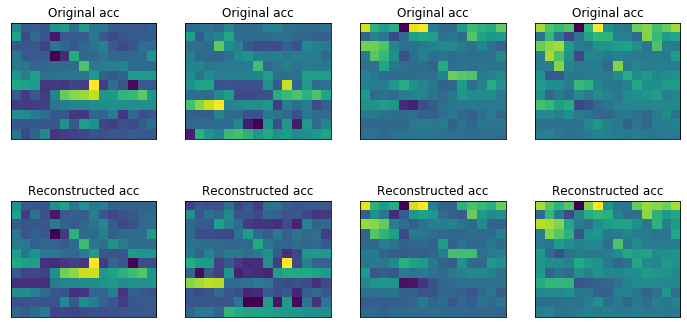

In [244]:
with torch.no_grad():
    number = 4
    plt.figure(figsize=(12, 6))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(12, 15))
        plt.title('Original acc')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstructed
        ax = plt.subplot(2, number, index + 1+ number)
        plt.imshow(reconstruction[index].numpy().reshape(12, 15))
        plt.title('Reconstructed acc')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        
    

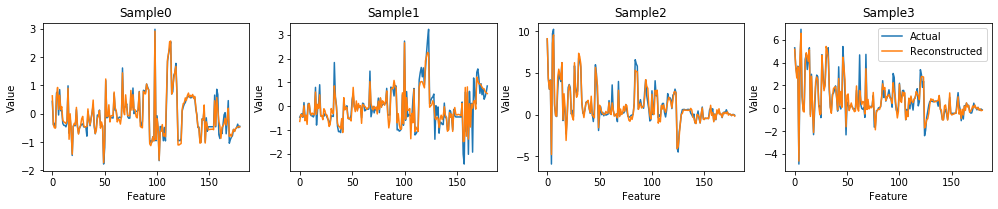

In [254]:
t = [i for i in range(180)]
count = 0 
with torch.no_grad():
    number = 4
    plt.figure(figsize=(17, 6))
    for index in range(number):
        # display original
        ax = plt.subplot(2, 4, index + 1)
        sensor_read = test_examples[index].numpy().reshape(180, 1)
        plt.plot(t,sensor_read, label = 'Actual')
        plt.xlabel('Feature')
        plt.ylabel('Value')
        plt.title('Sample'+str(index))

        # display reconstructed
        sensor_read_rec = reconstruction[index].numpy().reshape(180, 1)
        plt.plot(t,sensor_read_rec, label = 'Reconstructed')
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
plt.legend(loc = 'best')